# Lab Assignment 9
## Andrew Marquardt

In [15]:
# Libraries n' stuff
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp
from tclab import TCLab, clock, Historian, Plotter, setup

In [41]:
# Copied constants
CpH = 8.570225192333513 #Joules/degree C
CpS = 1.1198465579234749 #Joules/degree C
Ua = 0.03916910667788763 #Watts/degree C
Ub = 0.08256218948251515 #Watts/degree C
Uc = 0.03558351485126857 #Watts/degree C
a = 0.00016
P1 = 200
P2 = 100
Tamb = 21
SP = 45

In [42]:
# state space model
A = np.array([[-(Ua + Ub)/CpH, Ub/CpH], [Ub/CpS, -Ub/CpS]])
Bu = np.array([[a*P1/CpH], [0]])     # single column
Bd = np.array([[Ua/CpH], [0]])           # single column
C = np.array([[0, 1]])                   # single row

In [43]:
def tclab_observer(L, t_prev=0, x=[Tamb, Tamb], d=[Tamb]):
    while True:
        # yield current state estimate. Wait for message information
        # needed to update the state estimate for the next time step
        t, U, T_sensor, Tamb = yield x
        
        # prediction
        x = x + (t - t_prev)*(A@x + Bu@[U] + Bd@[Tamb])
        
        # correction
        x = x - (t - t_prev)*L@(C@x - np.array([T_sensor]))
        t_prev = t

In [55]:
def my_predictive_control(t_horizon=300, dt=2,alpha=0.01):
    # create time grid
    n = round(t_horizon/dt)
    t_grid = np.linspace(0, t_horizon, n+1)
    
    # create decision variables and all parts of the model
    # that do not depend on information from the event loop
    u = {t: cp.Variable(1, nonneg=True) for t in t_grid}
    x = {t: cp.Variable(2) for t in t_grid}
    y = {t: cp.Variable(1) for t in t_grid}
    output = [y[t] == C@x[t] for t in t_grid]
    inputs = [u[t] <= 100 for t in t_grid]

    MV = 0
    while True:
        # yield MV, then wait for new information to update MV
        SP, Th, Ts, Tamb = yield MV
        objective = cp.Minimize((1-alpha)*sum((y[t]-SP)**2 for t in t_grid)
                               + alpha*sum((u[t]-u[t-dt])**2 for t in t_grid[1:]))
        model = [x[t] == x[t-dt] + dt*(A@x[t-dt] + Bu@u[t-dt] + Bd@[Tamb]) for t in t_grid[1:]]
        IC = [x[0] == np.array([Th, Ts])]
        problem = cp.Problem(objective,  model + IC + output + inputs)
        problem.solve(warm_start=True)
        MV = u[0].value[0]

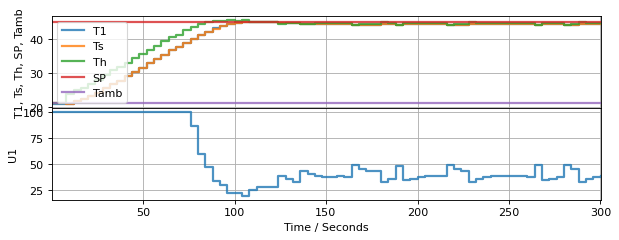

TCLab Model disconnected successfully.


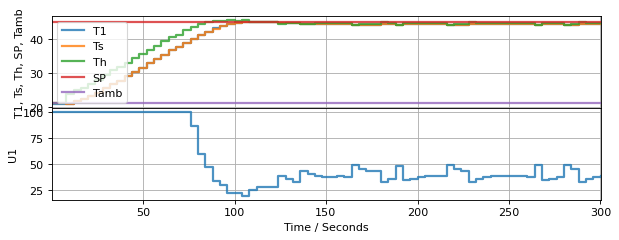

In [59]:
t_final = 300
t_step = 3

# create a controller instance
controller = my_predictive_control(dt=t_step)
U1 = next(controller)

# create estimator instance
L = np.array([[0.4], [0.2]])
observer = tclab_observer(L)
Th, Ts = next(observer)

# execute the event loop
TCLab = setup(connected=False, speedup=5)
with TCLab() as lab:
    h = Historian([('SP', lambda: SP), 
                   ('T1', lambda: T1), 
                   ('U1', lambda: U1), 
                   ('Th', lambda: Th), 
                   ('Ts', lambda: Ts),
                   ('Tamb', lambda: Tamb)])
    p = Plotter(h, t_final, layout=[['T1','Ts','Th', 'SP', 'Tamb'], ['U1']])
    for t in clock(t_final, 4):
        T1 = lab.T1 
        Th, Ts = observer.send([t, U1, T1, Tamb])
        U1 = controller.send([SP, Th, Ts, Tamb])
        lab.Q1(U1)
        p.update(t)

4-state model

In [193]:
# build operators and vectors
A = np.array([[-(Ua + Ub + Uc)/CpH, Ub/CpH, Uc/CpH, 0], 
              [Ub/CpS, -Ub/CpS, 0, 0],
              [Uc/CpH, 0, -(Ua + Ub + Uc)/CpH, Ub/CpH],
              [0, 0, Ub/CpS, -Ub/CpS]])

Bu = np.array([[a*P1/CpH, 0], [0, 0], [0, a*P2/CpH], [0, 0]])

Bd = np.array([[Ua/CpH], [0], [Ua/CpH], [0]])

C = np.array([[0, 1, 0, 0], [0, 0, 0, 1]])

L = np.array([[0.4,0],[0.2,0],[0,0.4],[0,0.2]])

# initial values for states and inputs
u_initial = np.array([0, 0])
d_initial = np.array([Tamb])
x_initial = np.array([Tamb, Tamb, Tamb, Tamb])

In [197]:
def my_predictive_control_4state(t_horizon=300, dt=2, alpha=0.05):
    # create time grid
    n = round(t_horizon/dt)
    t_grid = np.linspace(0, t_horizon, n+1)
    
    # create decision variables and all parts of the model
    # that do not depend on information from the event loop
    u = {t: cp.Variable(2, nonneg=True) for t in t_grid}
    x = {t: cp.Variable(4) for t in t_grid}
    y = {t: cp.Variable(2) for t in t_grid}
    output = [y[t] == C@x[t] for t in t_grid]
    input1 = [u[t][0] <= 100 for t in t_grid]
    input2 = [u[t][1] <= 100 for t in t_grid]

    MV1 = 0
    MV2 = 0
    while True:
        # yield MV, then wait for new information to update MV
        SP1, SP2, Th1, Ts1, Th2, Ts2, Tamb = yield MV1,MV2
        objective1 = cp.Minimize((1-alpha)*sum((y[t][0]-SP1)**2 for t in t_grid)
                               + alpha*sum((u[t][0]-u[t-dt][0])**2 for t in t_grid[1:]))
        objective2 = cp.Minimize((1-alpha)*sum((y[t][1]-SP2)**2 for t in t_grid)
                               + alpha*sum((u[t][1]-u[t-dt][1])**2 for t in t_grid[1:]))
        model = [x[t] == x[t-dt] + dt*(A@x[t-dt] + Bu@u[t-dt] + Bd@[Tamb]) for t in t_grid[1:]]
        IC = [x[0] == np.array([Th1, Ts1, Th2, Ts2])]
        problem = cp.Problem(objective1 + objective2,  model + IC + output + input1 + input2)
        problem.solve(warm_start=True)
        MV1 = u[0].value[0]
        MV2 = u[0].value[1]

In [198]:
def tclab_observer_4state(L, t_prev=0, x_now=np.array([Tamb,Tamb,Tamb,Tamb]), d=[Tamb]):
    while True:
        # yield current state estimate. Wait for message information
        # needed to update the state estimate for the next time step
        t,U1,U2,T1,T2 = yield x_now
        
        # prediction
        u = [U1,U2]
        x_predict = x_now + (t - t_prev)*(np.dot(A,x_now) + np.dot(Bu,u) + np.dot(Bd,d))
        
        # correction
        y = np.array([T1, T2])
        x_correct = x_predict - (t - t_prev)*np.dot(L, np.dot(C, x_predict) - y)
        t_prev = t
        x_now = x_correct

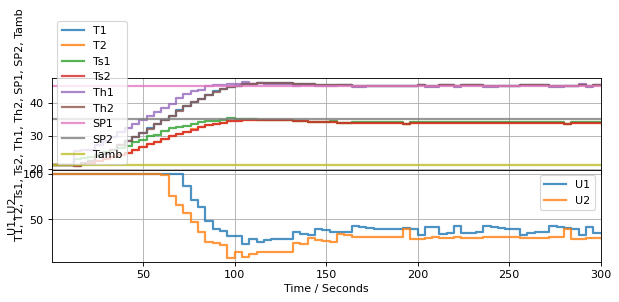

TCLab Model disconnected successfully.


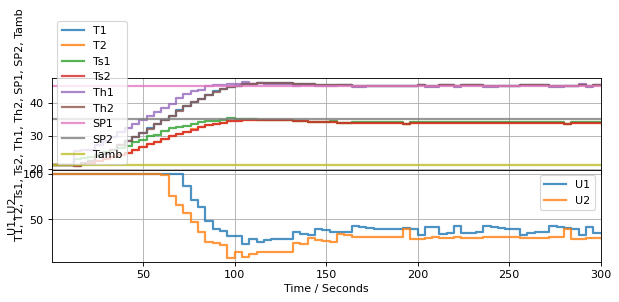

In [199]:
t_final = 300
t_step = 3
SP1 = 45
SP2 = 35

# create a controller instance
controller = my_predictive_control_4state(dt=t_step)
U1,U2 = next(controller)

# create estimator instance
observer = tclab_observer_4state(L)
Th1, Th2, Ts1, Ts2 = next(observer)

# execute the event loop
TCLab = setup(connected=False, speedup=5)
with TCLab() as lab:
    h = Historian([('SP1', lambda: SP1),
                   ('SP2', lambda: SP2),
                   ('T1', lambda: T1), 
                   ('T2', lambda: T2),
                   ('U1', lambda: U1),
                   ('U2', lambda: U2),
                   ('Th1', lambda: Th1),
                   ('Th2', lambda: Th2),
                   ('Ts1', lambda: Ts1),
                   ('Ts2', lambda: Ts2),
                   ('Tamb', lambda: Tamb)])
    p = Plotter(h, t_final, layout=[['T1','T2','Ts1','Ts2','Th1','Th2','SP1','SP2','Tamb'], ['U1','U2']])
    for t in clock(t_final, 4):
        T1 = lab.T1
        T2 = lab.T2
        Th1, Th2, Ts1, Ts2 = observer.send([t,U1,U2,T1,T2])
        U1,U2 = controller.send([SP1, SP2, Th1, Th2, Ts1, Ts2, Tamb])
        print(U1)
        print(U2)
        lab.Q1(U1)
        lab.Q2(U2)
        p.update(t)

Production Run

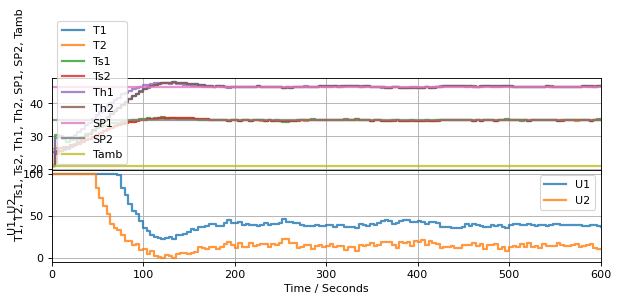

TCLab disconnected successfully.


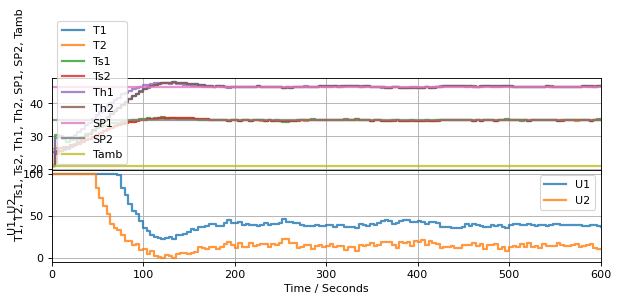

In [200]:
from tclab import TCLab, clock, Historian, Plotter
t_final = 600
t_step = 3
SP1 = 45
SP2 = 35

# create a controller instance
controller = my_predictive_control_4state(dt=t_step)
U1,U2 = next(controller)

# create estimator instance
observer = tclab_observer_4state(L)
Th1, Th2, Ts1, Ts2 = next(observer)

# execute the event loop
with TCLab() as lab:
    h = Historian([('SP1', lambda: SP1),
                   ('SP2', lambda: SP2),
                   ('T1', lambda: T1), 
                   ('T2', lambda: T2),
                   ('U1', lambda: U1),
                   ('U2', lambda: U2),
                   ('Th1', lambda: Th1),
                   ('Th2', lambda: Th2),
                   ('Ts1', lambda: Ts1),
                   ('Ts2', lambda: Ts2),
                   ('Tamb', lambda: Tamb)])
    p = Plotter(h, t_final, layout=[['T1','T2','Ts1','Ts2','Th1','Th2','SP1','SP2','Tamb'], ['U1','U2']])
    for t in clock(t_final, 4):
        T1 = lab.T1
        T2 = lab.T2
        Th1, Th2, Ts1, Ts2 = observer.send([t,U1,U2,T1,T2])
        U1,U2 = controller.send([SP1, SP2, Th1, Th2, Ts1, Ts2, Tamb])
        print(U1)
        print(U2)
        lab.Q1(U1)
        lab.Q2(U2)
        p.update(t)